# Just for testing random things

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from functools import partial
import os
import sys
import umap
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config
from synbio_morpher.utils.misc.string_handling import string_to_tuple_list
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.srv.parameter_prediction.simulator import SIMULATOR_UNITS
from synbio_morpher.utils.misc.numerical import make_symmetrical_matrix_from_sequence, triangular_sequence
from synbio_morpher.utils.misc.type_handling import flatten_listlike, get_first_elements
from synbio_morpher.utils.misc.string_handling import prettify_keys_for_label
from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all
from synbio_morpher.utils.results.analytics.timeseries import get_precision
from synbio_morpher.utils.common.testing.shared import CONFIG
from synbio_morpher.utils.parameter_inference.interpolation_grid import create_parameter_range
from explanations.data_enhancing import enhance_data


2023-08-29 09:55:19.226798: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-29 09:55:19.226859: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-29 09:55:19.226863: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
import numpy as np
import scipy.integrate
import scipy.optimize
import matplotlib

# import be150

import bokeh.io
import bokeh.plotting

bokeh.io.output_notebook()

Loading BokehJS ...

In [4]:
fn = '../data/ensemble_mutation_effect_analysis/2023_07_17_105328/summarise_simulation/tabulated_mutation_info.csv'
data = pd.read_csv(fn)

In [5]:
data[get_true_interaction_cols(data, 'binding_rates_dissociation')].min()

binding_rates_dissociation_0-0    5.973420e-05
binding_rates_dissociation_0-1    1.086889e-05
binding_rates_dissociation_0-2    1.000490e-07
binding_rates_dissociation_1-0    1.086889e-05
binding_rates_dissociation_1-1    5.878606e-05
binding_rates_dissociation_1-2    1.345129e-07
binding_rates_dissociation_2-0    1.000490e-07
binding_rates_dissociation_2-1    1.345129e-07
binding_rates_dissociation_2-2    5.785297e-05
dtype: float64

In [6]:
dfm = data.melt(
    id_vars=['circuit_name', 'mutation_name'], 
    value_vars=get_true_interaction_cols(data, 'binding_rates_dissociation'), 
    var_name='idx', 
    value_name='binding_rates_dissociation')

<AxesSubplot: xlabel='binding_rates_dissociation', ylabel='Count'>

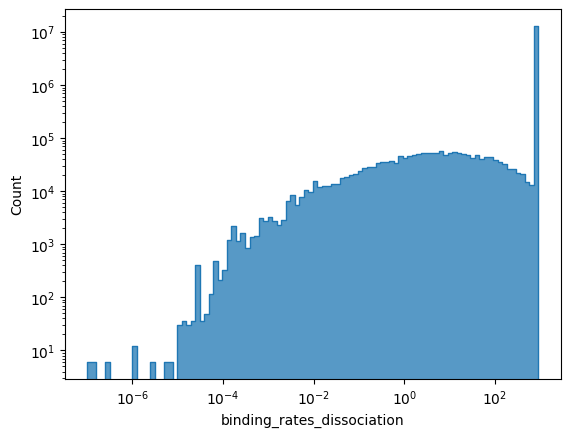

In [7]:
sns.histplot(dfm, x='binding_rates_dissociation', element='step', bins=100, log_scale=[True, True])

In [8]:
np.log10(dfm['binding_rates_dissociation'].min())

-6.999787247823895

In [9]:
np.log10(dfm['binding_rates_dissociation'].max())

2.9542422681645455

In [10]:
np.linspace(np.log10(dfm['binding_rates_dissociation'].min()), np.log10(dfm['binding_rates_dissociation'].max()), 10)

array([-6.99978725, -5.89378397, -4.78778069, -3.68177741, -2.57577413,
       -1.46977085, -0.36376757,  0.74223571,  1.84823899,  2.95424227])

In [11]:
np.power(10, np.linspace(np.log10(dfm['binding_rates_dissociation'].min()), np.log10(dfm['binding_rates_dissociation'].max()), 9))

array([1.00049000e-07, 1.75576522e-06, 3.08120172e-05, 5.40721727e-04,
       9.48915433e-03, 1.66525674e-01, 2.92236790e+00, 5.12847897e+01,
       8.99999500e+02])

In [51]:
ifn = '../data/parameter_based_simulation/2023_08_24_114212/initial_steady_states.npy'
sfn = '../data/parameter_based_simulation/2023_08_24_114212/steady_states.npy'
ofn = '../data/parameter_based_simulation/2023_08_24_114212/overshoot.npy'

i = np.load(ifn)
s = np.load(sfn)
o = np.load(ofn)

# p = get_precision(i, s, i[0], s[0])
# orat = jax.tree_util.tree_map(lambda xi, xs, xo: np.interp(xo, [xi, xs], [0, 1]), i, s, o)
orat = np.where(s != i, np.abs(o / (s - i)), 0)

/tmp/ipykernel_1055295/2185539857.py:11: RuntimeWarning: divide by zero encountered in divide
  orat = np.where(s != i, np.abs(o / (s - i)), 0)
/tmp/ipykernel_1055295/2185539857.py:11: RuntimeWarning: invalid value encountered in divide
  orat = np.where(s != i, np.abs(o / (s - i)), 0)


In [53]:

oratfn = '../data/parameter_based_simulation/2023_08_24_114212/overshoot_asratio.npy'

np.save(oratfn, orat)

: 

In [33]:
idx1 = tuple([0, 0, 0, 0, 0, 0, 3]) 
idx2 = tuple([2, 0, 0, 0, 0, 0, 3]) 

print('sig', i[idx1], s[idx1])
print('out', i[idx2], s[idx2])

sig 0.022138242 2.7574089
out 4.107996 2.8409286


In [34]:
print('sig', s[idx1] - i[idx1])
print('out', s[idx2] - i[idx2])

sig 2.7352705
out -1.2670674


In [35]:
print('sig', (s[idx1] - i[idx1]) / i[idx1])
print('out', (s[idx2] - i[idx2]) / i[idx2])

sig 123.5541
out -0.3084393


In [40]:
pp = ((s[idx2] - i[idx2]) / i[idx2]) / ((s[idx1] - i[idx1]) / i[idx1])
print('p calc', 1 / np.abs(pp))
print('p real', p[idx2[:]])

p calc 400.5783010631401
p real 400.5783


In [42]:
p.shape

(3, 9, 9, 9, 9, 9, 9)

<AxesSubplot: >

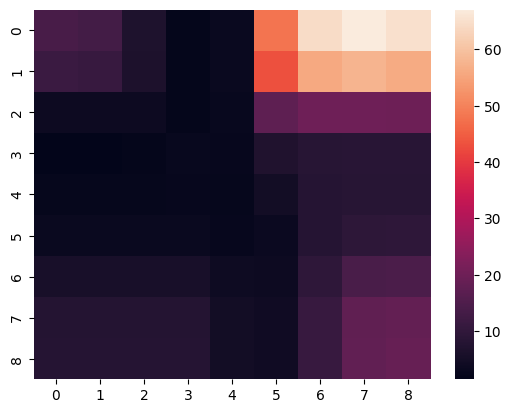

In [44]:
sns.heatmap(p[1, :, :, 0, 0, 0, 0]) 

In [13]:
stop
pfn = '../data/parameter_based_simulation/2023_08_24_114212/precision_wrt_species-6.npy'

np.save(pfn, p)

NameError: name 'stop' is not defined